# 라이브러리

In [1]:
import os
import math

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import cv2

from PIL import Image
from skimage.io import imread
from skimage.transform import resize
from glob import glob

import tensorflow as tf

from tensorflow import data
from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation
from tensorflow.keras import layers, Input, Model
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import Adam

# 데이터 확인, 이미지 분할

In [2]:
data_path = './cityscapes/train/'
print("number of train examples :", len(os.listdir(data_path)))

number of train examples : 1000


In [3]:
# 이미지 하나를 열어 크기 확인
f = data_path + os.listdir(data_path)[0]
img = cv2.imread(f, cv2.IMREAD_COLOR)
print(img.shape)

(256, 512, 3)


In [4]:
#(256, 256, 3) 크기의 2개 이미지로 분할

def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

def denormalize(x):
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1] // 2
    real_image = img[:, :w, :] 
    real_image = tf.cast(real_image, tf.float32)
    input_image = img[:, w:, :] 
    input_image = tf.cast(input_image, tf.float32)
    return normalize(input_image), normalize(real_image)

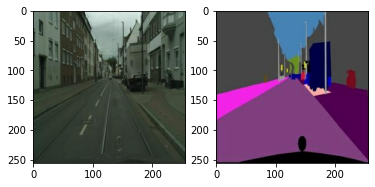

In [8]:
f = data_path + os.listdir(data_path)[1]
real_image, input_image = load_img(f)

plt.figure(figsize=(6,3))
plt.subplot(1,2,1); plt.imshow(denormalize(input_image))
plt.subplot(1,2,2); plt.imshow(denormalize(real_image))

# Augmentation

In [40]:
@tf.function() # 빠른 텐서플로 연산을 위해 @tf.function()을 사용합니다. 
def apply_augmentation(sketch, colored):
    stacked = tf.concat([sketch, colored], axis=-1)
    
    _pad = tf.constant([[30,30],[30,30],[0,0]])
    if tf.random.uniform(()) < .5:
        padded = tf.pad(stacked, _pad, "REFLECT")
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.)

    # 랜덤 이미지 왜곡
    out = image.random_crop(padded, size=[256, 256, 6])
    out = image.random_flip_left_right(out)
    out = image.random_flip_up_down(out)
    
    # 50% 확률로 이미지 회전
    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = image.rot90(out, k=degree)
    
    return out[...,:3], out[...,3:]  

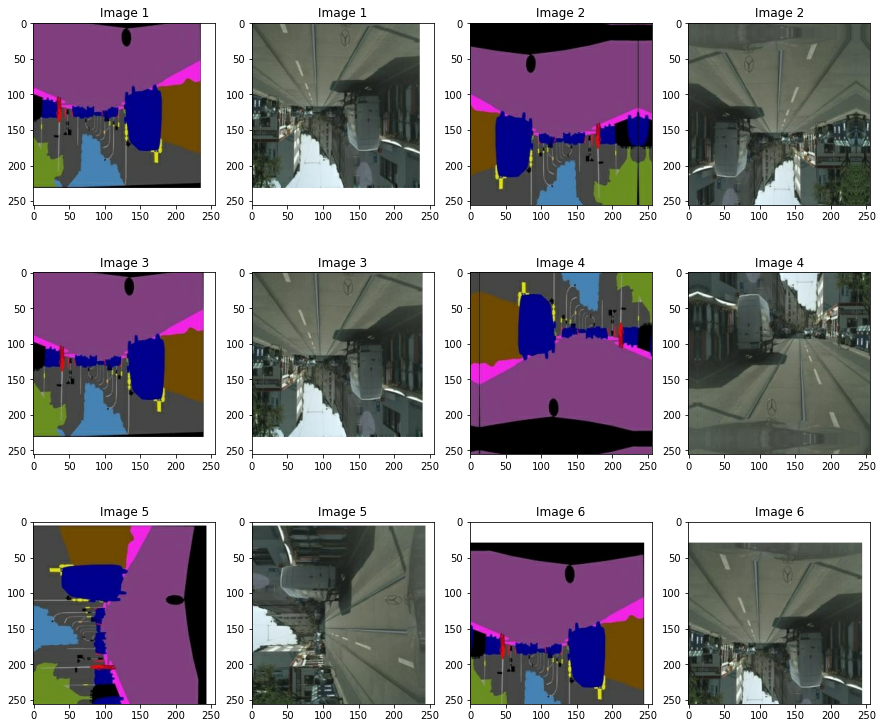

In [41]:
plt.figure(figsize=(15,13))
img_n = 1
for i in range(1, 13, 2):
    augmented_sketch, augmented_colored = apply_augmentation(input_image, real_image)
    
    plt.subplot(3,4,i)
    plt.imshow(denormalize(augmented_sketch)); plt.title(f"Image {img_n}")
    plt.subplot(3,4,i+1); 
    plt.imshow(denormalize(augmented_colored)); plt.title(f"Image {img_n}")
    img_n += 1

# 학습 데이터 이미지

In [11]:
def get_train(img_path):
    sketch, colored = load_img(img_path)
    sketch, colored = apply_augmentation(sketch, colored)
    return sketch, colored

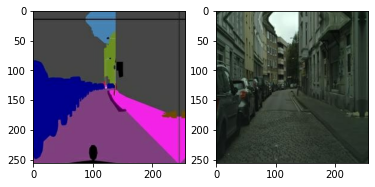

In [12]:
train_images = data.Dataset.list_files(data_path + "*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(4)

sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
sketch, colored = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

plt.figure(figsize=(6,3))
plt.subplot(1,2,1); plt.imshow(sketch[0].astype(np.uint8))
plt.subplot(1,2,2); plt.imshow(colored[0].astype(np.uint8))

# U-Net Generator

In [14]:
class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu = layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

In [15]:
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

In [16]:
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        features = features[:-1]
                    
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

In [17]:
UNetGenerator().get_summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
encode_block (EncodeBlock)      (None, 128, 128, 64) 3072        input_1[0][0]                    
__________________________________________________________________________________________________
encode_block_1 (EncodeBlock)    (None, 64, 64, 128)  131584      encode_block[0][0]               
__________________________________________________________________________________________________
encode_block_2 (EncodeBlock)    (None, 32, 32, 256)  525312      encode_block_1[0][0]             
______________________________________________________________________________________________

# Discriminator

In [18]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 

In [31]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.block1 = layers.Concatenate()
        self.blocks = [
            DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True),
            DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True),
            DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True),
            DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True),
            DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        ]
        self.sigmoid = layers.Activation("sigmoid")
            
    def call(self, x, y):
        out = self.block1([x, y])
        for block in self.blocks:
            out = block(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()


In [32]:
Discriminator().get_summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate_115 (Concatenate)   (None, 256, 256, 6)  0           input_4[0][0]                    
                                                                 input_5[0][0]                    
__________________________________________________________________________________________________
disc_block_15 (DiscBlock)       (None, 128, 128, 64) 6144        concatenate_115[0][0]      

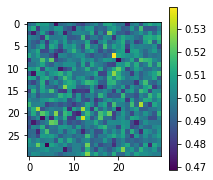

In [21]:
x = tf.random.normal([1,256,256,3])
y = tf.random.uniform([1,256,256,3])

disc_out = Discriminator()(x, y)

plt.figure(figsize=(3,3))
plt.imshow(disc_out[0, ... ,0])
plt.colorbar()

# 학습

In [22]:
bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)

In [23]:
gene_opt = Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = Adam(2e-4, beta_1=.5, beta_2=.999)

In [38]:
@tf.function
def train_step(sketch, real_colored):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_colored = generator(sketch, training=True)
        # Discriminator 예측
        fake_disc = discriminator(sketch, fake_colored, training=True)
        real_disc = discriminator(sketch, real_colored, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_colored, real_colored, fake_disc)
        # lambda 를 100에서 5로 조정, 
        # generator 의 목소리를 더 높여줌.
        gene_total_loss = gene_loss + (5 * l1_loss)
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

In [39]:
EPOCHS = 10

generator = UNetGenerator()
discriminator = Discriminator()
history = {'gen_loss':[], 'l1_loss':[], 'disc_loss':[]}
steps = len(train_images)

for epoch in range(1, EPOCHS+1):
    for i, (sketch, colored) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(sketch, colored)
        history['gen_loss'].append(g_loss)
        history['l1_loss'].append(l1_loss)
        history['disc_loss'].append(d_loss)      
        
        elapsed = (i/steps) * 100
        if elapsed % 10 == 0:
            print('{:3}%'.format(int(elapsed)), end=' ')
            
        # 50회 반복마다 손실을 출력합니다.
        if (i+1) % steps == 0:
            print('\n\n')
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

  0%  10%  20%  30%  40%  50%  60%  70%  80%  90% 


EPOCH[1] - STEP[250]                     
Generator_loss:0.7053                     
L1_loss:0.2343                     
Discriminator_loss:1.2915

  0%  10%  20%  30%  40%  50%  60%  70%  80%  90% 


EPOCH[2] - STEP[250]                     
Generator_loss:0.9271                     
L1_loss:0.2213                     
Discriminator_loss:1.4259

  0%  10%  20%  30%  40%  50%  60%  70%  80%  90% 


EPOCH[3] - STEP[250]                     
Generator_loss:0.7200                     
L1_loss:0.1919                     
Discriminator_loss:1.3810

  0%  10%  20%  30%  40%  50%  60%  70%  80%  90% 


EPOCH[4] - STEP[250]                     
Generator_loss:0.7600                     
L1_loss:0.1871                     
Discriminator_loss:1.4692

  0%  10%  20%  30%  40%  50%  60%  70%  80%  90% 


EPOCH[5] - STEP[250]                     
Generator_loss:0.8090                     
L1_loss:0.1676                     
Discriminator_loss:1.3

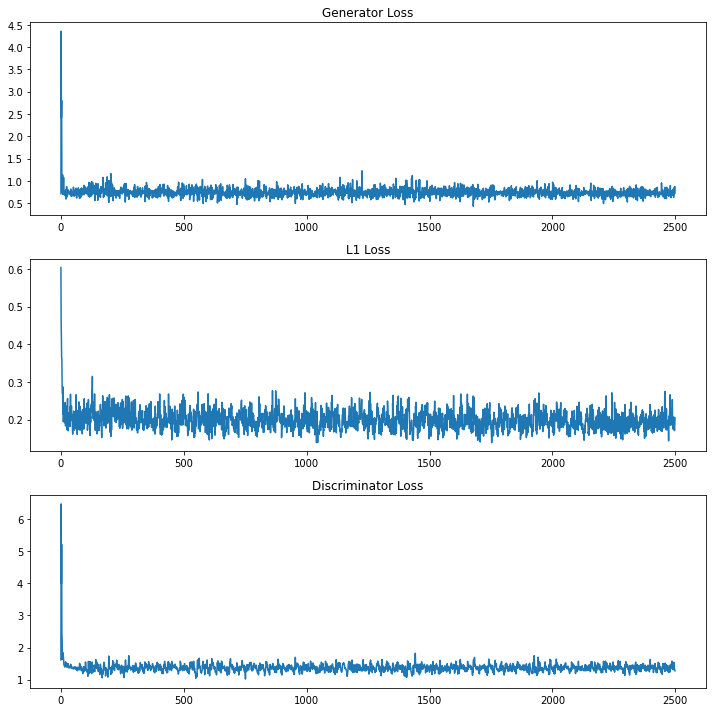

In [42]:
plt.figure(figsize=(10,10))

plt.subplot(311)
plt.plot(history['gen_loss'])
plt.title('Generator Loss')

plt.subplot(312)
plt.plot(history['l1_loss'])
plt.title('L1 Loss')

plt.subplot(313)
plt.plot(history['disc_loss'])
plt.title('Discriminator Loss')

plt.tight_layout()
plt.show()

람다를 100에서 5로 조정한 결과 Loss 진동폭이 작아짐.

# Test

In [27]:
test_path = './cityscapes/val/'
print("number of train examples :", len(os.listdir(test_path)))

number of train examples : 5


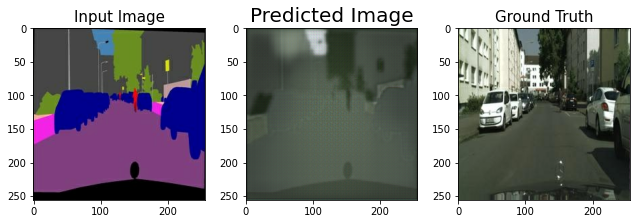

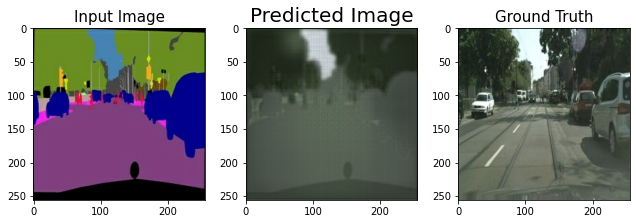

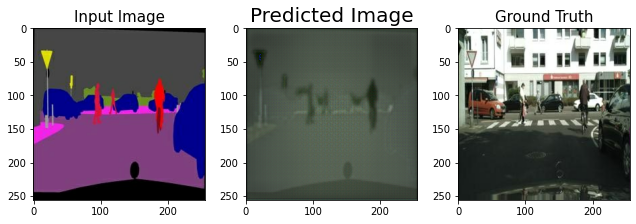

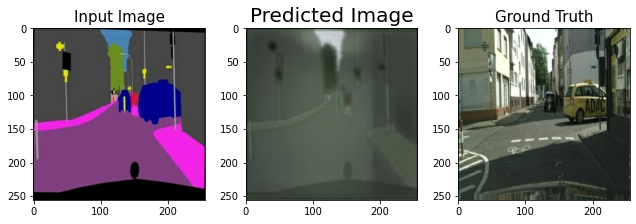

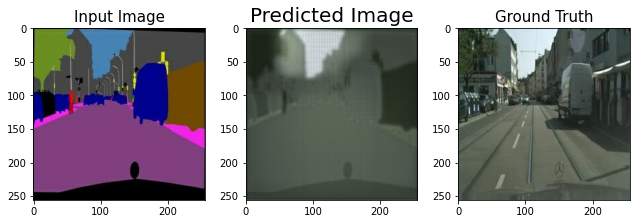

In [36]:
#도로 이미지 만들기
for i in range(5):
    f = test_path + os.listdir(test_path)[i]
    input_image, real_image = load_img(f)

    pred = generator(tf.expand_dims(input_image, 0))
    pred = denormalize(pred)

    plt.figure(figsize=(9,3))
    plt.subplot(1,3,1); plt.imshow(denormalize(input_image)); plt.title('Input Image', fontsize=15)
    plt.subplot(1,3,2); plt.imshow(pred[0]); plt.title('Predicted Image', fontsize=20)
    plt.subplot(1,3,3); plt.imshow(denormalize(real_image)); plt.title('Ground Truth', fontsize=15)
    plt.tight_layout()